# Scenario D - Peakshape Variation

In this scenario the peakshape in a spectrum with a fixed number of peaks is varied from Gaussian (n = 0.0) to Lorentzian (n = 1.0). All datasets contain 3 peaks and the noise level is kept constant at 1%.

The model used in the inference of the parameters is formulated as follows:

\begin{equation}
\large y = f(x) = \sum\limits_{m=1}^M \big[A_m \cdot f_{pseudo-Voigt}(x)\big] + \epsilon
\end{equation}

where:

\begin{equation}
\large f_{pseudo-Voigt}(x) = \eta \cdot \frac{\sigma_m^2}{(x-\mu_m)^2 + \sigma_m^2} + (1 - \eta) \cdot e^{-\frac{(x-\mu_m)^2}{2\cdot\sigma_m^2}}
\end{equation}

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az

#az.style.use('arviz-darkgrid')

print('Running on PyMC3 v{}'.format(pm.__version__))

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC3 v3.8


## Import local modules

In [2]:
import os
import sys
sys.path.append('../../modules')
import datagen as dg
import models as mdl
import results as res
import figures as fig
import settings as cnf

## Local configuration

In [3]:
# output for results and images
out_path      = './output_peakshape'
file_basename = out_path + '/scenario_peakshape'
        
conf = {}
    
# scenario name
conf['scenario'] = 'peakshape variation'
    
# initialization method for sampler
conf['init_mode'] = 'adapt_diag'

# probabilistic model (priors)
conf['prior_model'] = 'lognormal'

# provide peak positions to the model as testvalues ('yes'/'no')
conf['peak_info'] = 'yes'

# model mode ('train'/eval')
conf['model_mode'] = 'train'

# data mode ('generate'/'preload')
conf['data_mode'] = 'generate'

# dataset directory (needed for 'preload' data mode)
#conf['dataset_dir'] = './input_datasets'

# number of cores to run sampling chains on
conf['ncores'] = 2

# number of samples per chain
conf['nsamples'] = 2000

In [4]:
# if the output dir does not exist, create it
if not os.path.exists(out_path):
    os.makedirs(out_path)

conf

{'scenario': 'peakshape variation',
 'init_mode': 'adapt_diag',
 'prior_model': 'lognormal',
 'peak_info': 'yes',
 'model_mode': 'train',
 'data_mode': 'generate',
 'ncores': 2,
 'nsamples': 2000}

## Save configuration

In [5]:
cnf.save(out_path, conf)

# Generate data and plot

In [6]:
# list of wavelengths (x-values)
xval = [i for i in range(200, 400, 2)]

ldata  = []
lpeaks = []
lpeakshape = []

# number of spectra per baseline variation
nsets  = 4

# peakshape weight factors (0 = Gauss, 1 = Lorentz)
peakshapes = [0.0, 0.25, 0.5, 0.75, 1.0]
lpeakshape = [ps for ps in peakshapes for i in range(nsets)]

# total number of datasets
tsets = nsets * len(peakshapes)
        
if conf['model_mode'] == 'train' and conf['data_mode'] == 'generate':
    # generate the datasets
    for ps in peakshapes:
        for i in range(nsets):
            df, peaks, _ = dg.data_generator(xvalues=xval, nsamples=15, npeaks=3, peakshape=ps)
            ldata.append(df)
            lpeaks.append(peaks)
            
    # save data and peak information to disk
    for i in range(len(ldata)):
        ldata[i].to_csv(out_path + '/dataset_%02d.csv' % (i+1), index=False)
    dg.data_save(out_path + '/peakinfo.csv', lpeaks)
        
elif conf['model_mode'] == 'train' and conf['data_mode'] == 'preload':           
    # load pre-generated datasets from disk
    ldata, lpeaks, _ = dg.data_load(tsets, conf['dataset_dir'])
    
else:        
    # load data from disk
    if conf['data_mode'] == 'preload':
        ldata, lpeaks, _ = dg.data_load(tsets, conf['dataset_dir'])
    else:
        ldata, lpeaks, _ = dg.data_load(tsets, out_path)

In [7]:
print("total number of peakshape variations    : {0}".format(len(peakshapes)))
print("total number of datasets per peakshape  : {0}".format(nsets))
print("total number of datasets per model      : {0}".format(tsets))
print("total number of inference runs          : {0}".format(nsets*len(peakshapes)**2))

total number of peakshape variations    : 5
total number of datasets per peakshape  : 4
total number of datasets per model      : 20
total number of inference runs          : 100


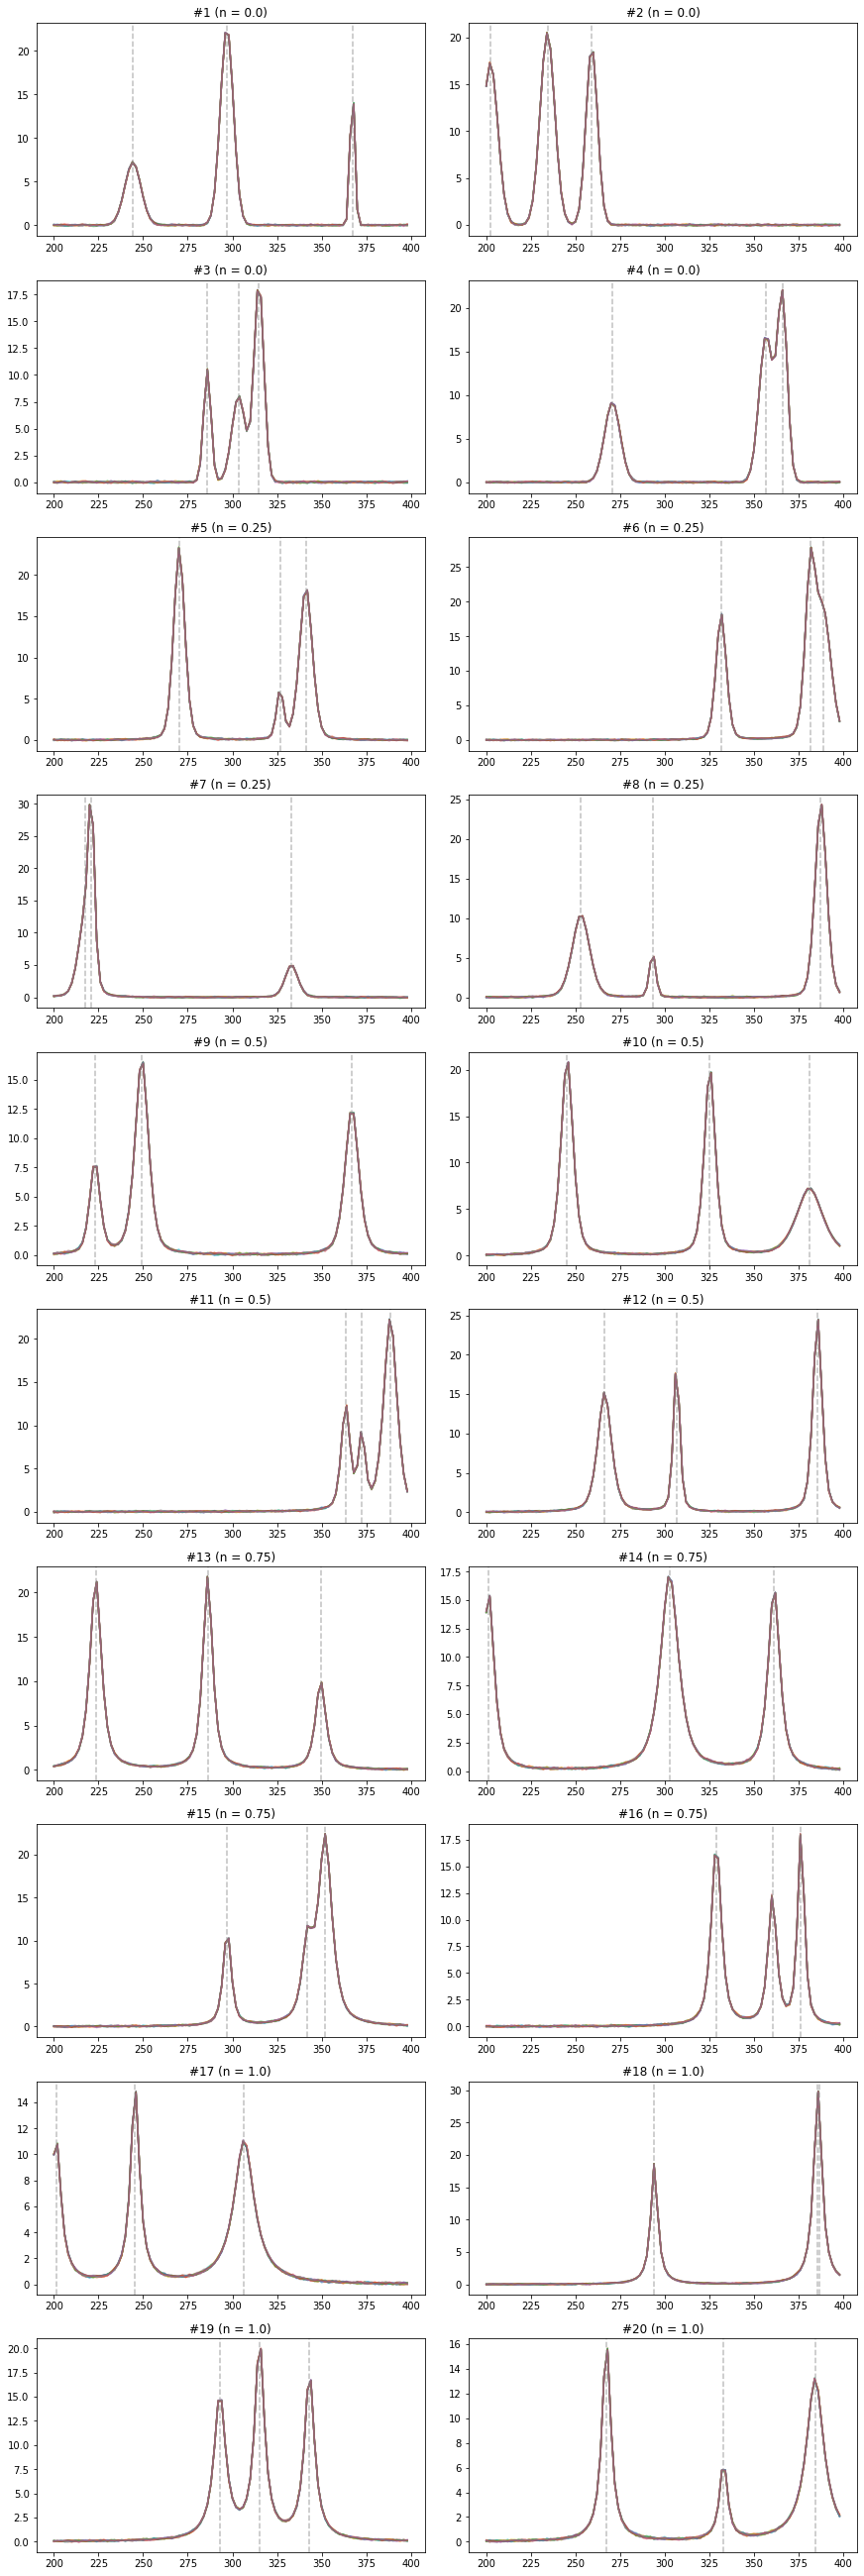

In [8]:
# plot datasets
fig.plot_datasets(ldata, lpeaks, dims=(int(tsets/2),2), figure_size=(12,int(tsets*(1.8))), 
                            savefig='yes', fname=file_basename, scenario='peakshape', labels=lpeakshape)

# Initialize models and run inference

In [9]:
# convert pandas data to numpy arrays
x_val = np.array(xval, dtype='float32')

# store dataset y-values in list
cols = ldata[0].columns
y_val = [ldata[i][cols].values for i in range(len(ldata))]

In [10]:
# initialize models and run inference
models = []
traces = []

# list of tuples with (model peakshape, data peakshape) combination
lmodbase = []

# actual run number
run = 1

# total number of inference runs
truns = nsets * len(peakshapes)**2

for ps in peakshapes:
    if conf['model_mode'] == 'train':
        # for each baseline model run inference on all spectra
        print("running: n = {0} peakshape model".format(ps))
    
    for i in range(len(ldata)):
        if conf['peak_info'] == 'yes':
            plist = lpeaks[i].flatten()
            plist.sort()
            model_g = mdl.model_pvoigt(xvalues=x_val, observations=y_val[i], npeaks=3, peakshape=ps,
                                  mu_peaks=plist, pmodel=conf['prior_model'])
        else:
            model_g = mdl.model_pvoigt(xvalues=x_val, observations=y_val[i], npeaks=3, peakshape=ps,
                                                  pmodel=conf['prior_model'])
                
        models.append(model_g)

        with model_g:
            if conf['model_mode'] == 'train':
                print("({2}/{3}) running inference on dataset #{0}/{1} [{4} model: {5} data]"
                      .format(i+1,len(ldata),run,truns,ps,lpeakshape[i]))
                trace_g = pm.sample(conf['nsamples'], init=conf['init_mode'], cores=conf['ncores'])
                lmodbase += [(ps,lpeakshape[i])]
                traces.append(trace_g)
                # save inference results
                pm.backends.text.dump(out_path + '/traces_%02d' % (run), trace_g)
            else:
                # load traces from disk
                print("loading dataset #{0}/{1}".format(run,truns))
                trace_g = pm.backends.text.load(out_path + '/traces_%02d' % (run))
                traces.append(trace_g)
            run += 1

running: n = 0.0 peakshape model


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(1/100) running inference on dataset #1/20 [0.0 model: 0.0 data]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 1 divergences: 100%|██████████| 5000/5000 [00:13<00:00, 374.54draws/s]
The acceptance probability does not match the target. It is 0.8881646566601207, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9048828649686392, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(2/100) running inference on dataset #2/20 [0.0 model: 0.0 data]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:13<00:00, 363.95draws/s]
The acceptance probability does not match the target. It is 0.914425208702438, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8935514720194795, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(3/100) running inference on dataset #3/20 [0.0 model: 0.0 data]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:12<00:00, 406.04draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(4/100) running inference on dataset #4/20 [0.0 model: 0.0 data]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:15<00:00, 317.12draws/s]
The acceptance probability does not match the target. It is 0.8855238540417112, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9194172025782116, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(5/100) running inference on dataset #5/20 [0.0 model: 0.25 data]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 2 divergences: 100%|██████████| 5000/5000 [00:10<00:00, 498.01draws/s]
The acceptance probability does not match the target. It is 0.8821391162896205, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(6/100) running inference on dataset #6/20 [0.0 model: 0.25 data]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:16<00:00, 295.83draws/s]
The acceptance probability does not match the target. It is 0.8814050274990781, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8820972488144169, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(7/100) running inference on dataset #7/20 [0.0 model: 0.25 data]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:15<00:00, 323.74draws/s]
The acceptance probability does not match the target. It is 0.91168900858586, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(8/100) running inference on dataset #8/20 [0.0 model: 0.25 data]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 1 divergences: 100%|██████████| 5000/5000 [00:10<00:00, 458.88draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(9/100) running inference on dataset #9/20 [0.0 model: 0.5 data]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:11<00:00, 439.33draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(10/100) running inference on dataset #10/20 [0.0 model: 0.5 data]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:11<00:00, 436.84draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(11/100) running inference on dataset #11/20 [0.0 model: 0.5 data]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:13<00:00, 378.29draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(12/100) running inference on dataset #12/20 [0.0 model: 0.5 data]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 1 divergences: 100%|██████████| 5000/5000 [00:11<00:00, 431.86draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(13/100) running inference on dataset #13/20 [0.0 model: 0.75 data]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:09<00:00, 504.29draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(14/100) running inference on dataset #14/20 [0.0 model: 0.75 data]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:12<00:00, 386.79draws/s]
The acceptance probability does not match the target. It is 0.8788578981054789, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(15/100) running inference on dataset #15/20 [0.0 model: 0.75 data]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:12<00:00, 395.78draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(16/100) running inference on dataset #16/20 [0.0 model: 0.75 data]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:12<00:00, 391.05draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(17/100) running inference on dataset #17/20 [0.0 model: 1.0 data]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:17<00:00, 280.40draws/s]
The acceptance probability does not match the target. It is 0.8823046674818219, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(18/100) running inference on dataset #18/20 [0.0 model: 1.0 data]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:21<00:00, 237.97draws/s]
The acceptance probability does not match the target. It is 0.8788056296176722, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8896754797262247, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(19/100) running inference on dataset #19/20 [0.0 model: 1.0 data]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:11<00:00, 440.19draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(20/100) running inference on dataset #20/20 [0.0 model: 1.0 data]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:11<00:00, 428.79draws/s]


running: n = 0.25 peakshape model


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(21/100) running inference on dataset #1/20 [0.25 model: 0.0 data]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:16<00:00, 296.25draws/s]
The acceptance probability does not match the target. It is 0.8847161084854176, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8924208513091506, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(22/100) running inference on dataset #2/20 [0.25 model: 0.0 data]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:12<00:00, 409.90draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(23/100) running inference on dataset #3/20 [0.25 model: 0.0 data]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:12<00:00, 411.08draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(24/100) running inference on dataset #4/20 [0.25 model: 0.0 data]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:15<00:00, 326.25draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(25/100) running inference on dataset #5/20 [0.25 model: 0.25 data]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 3 divergences: 100%|██████████| 5000/5000 [00:13<00:00, 360.20draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9014485031876139, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.919585117381475, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(26/100) running inference on dataset #6/20 [0.25 model: 0.25 data]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:26<00:00, 190.49draws/s]
The acceptance probability does not match the target. It is 0.9105189302671324, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9277482687270457, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(27/100) running inference on dataset #7/20 [0.25 model: 0.25 data]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:35<00:00, 140.79draws/s]
The acceptance probability does not match the target. It is 0.9380154932242768, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.937103630177649, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(28/100) running inference on dataset #8/20 [0.25 model: 0.25 data]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 8 divergences: 100%|██████████| 5000/5000 [00:14<00:00, 346.85draws/s]
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8892924509790645, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9202635473525524, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(29/100) running inference on dataset #9/20 [0.25 model: 0.5 data]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 1 divergences: 100%|██████████| 5000/5000 [00:12<00:00, 401.13draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(30/100) running inference on dataset #10/20 [0.25 model: 0.5 data]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:15<00:00, 333.12draws/s]
The acceptance probability does not match the target. It is 0.8811214830997641, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(31/100) running inference on dataset #11/20 [0.25 model: 0.5 data]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:11<00:00, 420.31draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(32/100) running inference on dataset #12/20 [0.25 model: 0.5 data]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:13<00:00, 368.63draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(33/100) running inference on dataset #13/20 [0.25 model: 0.75 data]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:12<00:00, 406.55draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(34/100) running inference on dataset #14/20 [0.25 model: 0.75 data]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:12<00:00, 390.19draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(35/100) running inference on dataset #15/20 [0.25 model: 0.75 data]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:17<00:00, 286.23draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(36/100) running inference on dataset #16/20 [0.25 model: 0.75 data]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 1 divergences: 100%|██████████| 5000/5000 [00:15<00:00, 327.99draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(37/100) running inference on dataset #17/20 [0.25 model: 1.0 data]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:18<00:00, 277.65draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(38/100) running inference on dataset #18/20 [0.25 model: 1.0 data]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:31<00:00, 157.88draws/s]
The acceptance probability does not match the target. It is 0.8950544520344786, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8898864720946259, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(39/100) running inference on dataset #19/20 [0.25 model: 1.0 data]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:13<00:00, 384.55draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(40/100) running inference on dataset #20/20 [0.25 model: 1.0 data]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:14<00:00, 351.99draws/s]


running: n = 0.5 peakshape model


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(41/100) running inference on dataset #1/20 [0.5 model: 0.0 data]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 108 divergences: 100%|██████████| 5000/5000 [00:25<00:00, 196.16draws/s]
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7115932437015537, but should be close to 0.8. Try to increase the number of tuning steps.
There were 61 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6756526265525845, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(42/100) running inference on dataset #2/20 [0.5 model: 0.0 data]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:12<00:00, 396.72draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(43/100) running inference on dataset #3/20 [0.5 model: 0.0 data]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:12<00:00, 400.80draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(44/100) running inference on dataset #4/20 [0.5 model: 0.0 data]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:12<00:00, 400.75draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(45/100) running inference on dataset #5/20 [0.5 model: 0.25 data]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:10<00:00, 485.07draws/s]
The acceptance probability does not match the target. It is 0.9079580006803791, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(46/100) running inference on dataset #6/20 [0.5 model: 0.25 data]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:19<00:00, 262.37draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(47/100) running inference on dataset #7/20 [0.5 model: 0.25 data]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:27<00:00, 181.39draws/s]
The acceptance probability does not match the target. It is 0.9239790830510535, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9337845464283705, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(48/100) running inference on dataset #8/20 [0.5 model: 0.25 data]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:12<00:00, 407.51draws/s]
The acceptance probability does not match the target. It is 0.8801306963168326, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(49/100) running inference on dataset #9/20 [0.5 model: 0.5 data]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 6 divergences: 100%|██████████| 5000/5000 [00:14<00:00, 333.61draws/s]
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8807787176649785, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8789510116894484, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(50/100) running inference on dataset #10/20 [0.5 model: 0.5 data]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 2 divergences: 100%|██████████| 5000/5000 [00:14<00:00, 348.59draws/s]
The acceptance probability does not match the target. It is 0.9051055763085927, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8873041755638977, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(51/100) running inference on dataset #11/20 [0.5 model: 0.5 data]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 4 divergences: 100%|██████████| 5000/5000 [00:11<00:00, 432.22draws/s]
The acceptance probability does not match the target. It is 0.8961010952128718, but should be close to 0.8. Try to increase the number of tuning steps.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(52/100) running inference on dataset #12/20 [0.5 model: 0.5 data]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:14<00:00, 346.79draws/s]
The acceptance probability does not match the target. It is 0.9002440022889593, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9241290217950903, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(53/100) running inference on dataset #13/20 [0.5 model: 0.75 data]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:13<00:00, 380.90draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(54/100) running inference on dataset #14/20 [0.5 model: 0.75 data]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:13<00:00, 379.43draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(55/100) running inference on dataset #15/20 [0.5 model: 0.75 data]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:20<00:00, 242.25draws/s]
The acceptance probability does not match the target. It is 0.8791459398080842, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(56/100) running inference on dataset #16/20 [0.5 model: 0.75 data]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 2 divergences: 100%|██████████| 5000/5000 [00:16<00:00, 311.83draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(57/100) running inference on dataset #17/20 [0.5 model: 1.0 data]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:15<00:00, 319.07draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(58/100) running inference on dataset #18/20 [0.5 model: 1.0 data]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:39<00:00, 127.98draws/s]
The acceptance probability does not match the target. It is 0.9015188047443884, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(59/100) running inference on dataset #19/20 [0.5 model: 1.0 data]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:11<00:00, 435.10draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(60/100) running inference on dataset #20/20 [0.5 model: 1.0 data]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:19<00:00, 254.98draws/s]
The acceptance probability does not match the target. It is 0.8824586648831572, but should be close to 0.8. Try to increase the number of tuning steps.


running: n = 0.75 peakshape model


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(61/100) running inference on dataset #1/20 [0.75 model: 0.0 data]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 4 divergences: 100%|██████████| 5000/5000 [00:14<00:00, 337.19draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(62/100) running inference on dataset #2/20 [0.75 model: 0.0 data]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 1 divergences: 100%|██████████| 5000/5000 [00:12<00:00, 391.69draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(63/100) running inference on dataset #3/20 [0.75 model: 0.0 data]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:12<00:00, 402.16draws/s]
The acceptance probability does not match the target. It is 0.8786083067053936, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(64/100) running inference on dataset #4/20 [0.75 model: 0.0 data]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:11<00:00, 427.86draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(65/100) running inference on dataset #5/20 [0.75 model: 0.25 data]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:11<00:00, 419.05draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(66/100) running inference on dataset #6/20 [0.75 model: 0.25 data]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:16<00:00, 298.74draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(67/100) running inference on dataset #7/20 [0.75 model: 0.25 data]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:18<00:00, 264.74draws/s]
The acceptance probability does not match the target. It is 0.878763270204075, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8919373803741726, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(68/100) running inference on dataset #8/20 [0.75 model: 0.25 data]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:12<00:00, 394.44draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(69/100) running inference on dataset #9/20 [0.75 model: 0.5 data]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:12<00:00, 388.95draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(70/100) running inference on dataset #10/20 [0.75 model: 0.5 data]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:13<00:00, 374.80draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(71/100) running inference on dataset #11/20 [0.75 model: 0.5 data]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:14<00:00, 348.48draws/s]
The acceptance probability does not match the target. It is 0.8840711919447211, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(72/100) running inference on dataset #12/20 [0.75 model: 0.5 data]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:12<00:00, 391.49draws/s]
The acceptance probability does not match the target. It is 0.8818070880722454, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8890054982830087, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(73/100) running inference on dataset #13/20 [0.75 model: 0.75 data]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:16<00:00, 309.23draws/s]
The acceptance probability does not match the target. It is 0.9231274744132673, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9292015002681439, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(74/100) running inference on dataset #14/20 [0.75 model: 0.75 data]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 2 divergences: 100%|██████████| 5000/5000 [00:16<00:00, 296.90draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8876189605144854, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9169744219355006, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(75/100) running inference on dataset #15/20 [0.75 model: 0.75 data]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 1 divergences: 100%|██████████| 5000/5000 [00:20<00:00, 243.63draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9230397597215312, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(76/100) running inference on dataset #16/20 [0.75 model: 0.75 data]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 2 divergences: 100%|██████████| 5000/5000 [00:13<00:00, 362.55draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(77/100) running inference on dataset #17/20 [0.75 model: 1.0 data]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 3 divergences: 100%|██████████| 5000/5000 [00:14<00:00, 341.10draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(78/100) running inference on dataset #18/20 [0.75 model: 1.0 data]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [01:09<00:00, 72.34draws/s] 
The acceptance probability does not match the target. It is 0.9085596215671141, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9234920576392919, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(79/100) running inference on dataset #19/20 [0.75 model: 1.0 data]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:13<00:00, 369.09draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(80/100) running inference on dataset #20/20 [0.75 model: 1.0 data]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:14<00:00, 338.81draws/s]


running: n = 1.0 peakshape model


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(81/100) running inference on dataset #1/20 [1.0 model: 0.0 data]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:12<00:00, 402.82draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(82/100) running inference on dataset #2/20 [1.0 model: 0.0 data]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 1 divergences: 100%|██████████| 5000/5000 [00:13<00:00, 367.84draws/s]
The acceptance probability does not match the target. It is 0.8927131392934939, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(83/100) running inference on dataset #3/20 [1.0 model: 0.0 data]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:11<00:00, 432.83draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(84/100) running inference on dataset #4/20 [1.0 model: 0.0 data]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:14<00:00, 355.43draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(85/100) running inference on dataset #5/20 [1.0 model: 0.25 data]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:24<00:00, 208.10draws/s]
The acceptance probability does not match the target. It is 0.8866123895108458, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8969765923158719, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(86/100) running inference on dataset #6/20 [1.0 model: 0.25 data]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:13<00:00, 369.63draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(87/100) running inference on dataset #7/20 [1.0 model: 0.25 data]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:16<00:00, 309.02draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(88/100) running inference on dataset #8/20 [1.0 model: 0.25 data]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:14<00:00, 336.24draws/s]
The acceptance probability does not match the target. It is 0.8885869332811903, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(89/100) running inference on dataset #9/20 [1.0 model: 0.5 data]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:11<00:00, 445.79draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(90/100) running inference on dataset #10/20 [1.0 model: 0.5 data]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:10<00:00, 485.16draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(91/100) running inference on dataset #11/20 [1.0 model: 0.5 data]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:13<00:00, 360.05draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(92/100) running inference on dataset #12/20 [1.0 model: 0.5 data]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:11<00:00, 429.57draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(93/100) running inference on dataset #13/20 [1.0 model: 0.75 data]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:09<00:00, 523.44draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(94/100) running inference on dataset #14/20 [1.0 model: 0.75 data]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:10<00:00, 458.71draws/s]
The acceptance probability does not match the target. It is 0.8832219747435456, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8807196797237345, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(95/100) running inference on dataset #15/20 [1.0 model: 0.75 data]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:14<00:00, 344.56draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(96/100) running inference on dataset #16/20 [1.0 model: 0.75 data]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:11<00:00, 425.95draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(97/100) running inference on dataset #17/20 [1.0 model: 1.0 data]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:12<00:00, 395.65draws/s]
The acceptance probability does not match the target. It is 0.8961698536377706, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9056502018126039, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(98/100) running inference on dataset #18/20 [1.0 model: 1.0 data]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [04:38<00:00, 17.95draws/s]
The acceptance probability does not match the target. It is 0.9080053208882471, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(99/100) running inference on dataset #19/20 [1.0 model: 1.0 data]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 1 divergences: 100%|██████████| 5000/5000 [00:12<00:00, 411.95draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9127318171532891, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.903586395497254, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...


(100/100) running inference on dataset #20/20 [1.0 model: 1.0 data]


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, sigma_e, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 5000/5000 [00:12<00:00, 401.21draws/s]
The acceptance probability does not match the target. It is 0.8825552156266598, but should be close to 0.8. Try to increase the number of tuning steps.


# Model visualization

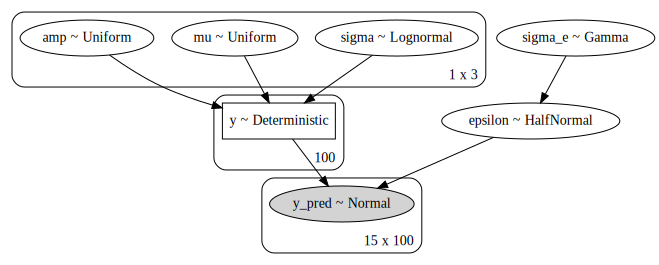

In [11]:
# display first model
pm.model_to_graphviz(models[0])

In [12]:
# save model figure as image
img = pm.model_to_graphviz(models[0])
img.render(filename=file_basename + '_model', format='png');

# Collect results and save

In [13]:
# posterior predictive traces
ppc = [pm.sample_posterior_predictive(traces[i], samples=500, model=models[i]) for i in range(len(traces))]

/home/ppsda/venv/ppsda/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 500/500 [00:01<00:00, 452.09it/s]
/home/ppsda/venv/ppsda/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 500/500 [00:01<00:00, 463.41it/s]


In [16]:
# various plots to inspect the inference results
varnames = mdl.get_varnames(traces[0])

#az.plot_trace(traces[2], varnames, compact=True);
#az.plot_trace(traces[2], varnames, divergences='top');
#az.plot_autocorr(traces[0], varnames);
#az.plot_posterior(traces[8], varnames);

#for idx, trace in enumerate(traces):
#    az.plot_forest(trace, var_names = varnames, r_hat=True, ess=True);

#az.summary(traces[20], varnames)

In [17]:
if conf['model_mode'] == 'train':
    # collect the results and display
    df = res.get_results_summary(traces, ppc, y_val, varnames, epsilon_real=0.05, sets=tsets, labels=lmodbase)
else:
    # load results from disk
    df = pd.read_csv(file_basename + '.csv')
    df.index += 1
    
    # create list of tuples with model/data combinations
    lm = df['model'].to_list()
    ld = df['data'].to_list()
    lmodbase = list(zip(lm,ld))
df

/home/ppsda/venv/ppsda/lib/python3.6/site-packages/arviz/stats/stats.py:1196: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


r_hat    mcse     ess      bfmi        r2         waic   epsilon  \
1      1.0  0.0001  4603.1  1.070962  0.999368 -2416.144457  0.107506   
2      1.0  0.0000  3681.1  1.022548  0.999916 -4765.623699  0.049271   
3      1.0  0.0000  4406.3  1.003102  0.998969 -2434.534303  0.106626   
4      1.0  0.0000  3339.7  1.045361  0.999891 -4735.034733  0.049778   
5      1.0  0.0003  5668.9  1.082656  0.997945  -319.933789  0.216327   
..     ...     ...     ...       ...       ...          ...       ...   
96     1.0  0.0002  4834.5  1.031103  0.996995  -549.591149  0.199667   
97     1.0  0.0000  3861.8  1.016320  0.999740 -4654.477366  0.051148   
98     1.0  0.0064  1711.7  1.001633  0.999896 -4805.565811  0.048639   
99     1.0  0.0000  3879.3  1.067771  0.999819 -4164.123278  0.060097   
100    1.0  0.0000  4331.8  1.024726  0.999393 -3275.331254  0.080614   

     epsilon_real  model  data  
1            0.05    0.0  0.00  
2            0.05    0.0  0.00  
3            0.05    0.0  0.00  
4            0.05    0.0  0.00  
5            0.05    0.0  0.25  
..            ...    ...   ...  
96           0.05    1.0  0.75  
97           0.05    1.0  1.00  
98           0.05    1.0  1.00  
99           0.05    1.0  1.00  
100          0.05    1.0  1.00  

[100 rows x 10 columns]

In [18]:
if conf['model_mode'] == 'train':
    # save results to .csv
    df.to_csv(file_basename + '.csv', index=False)

# Plot posterior

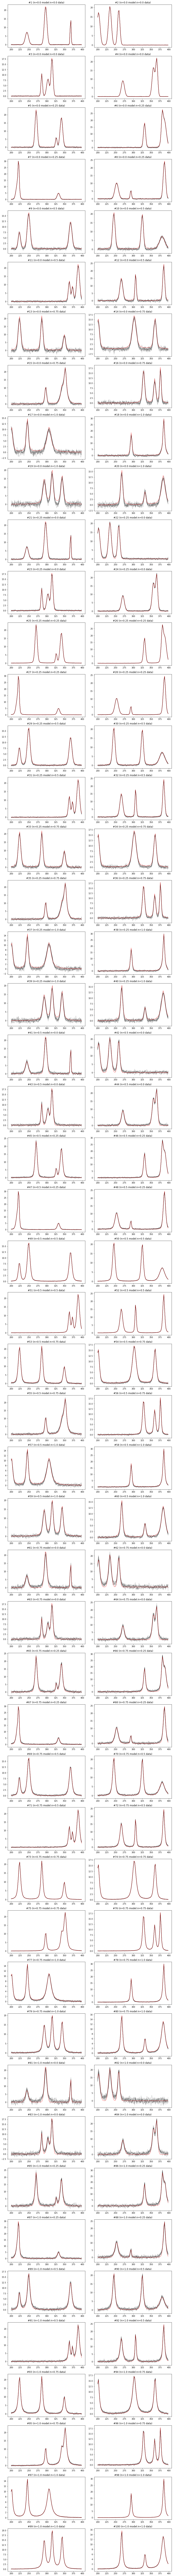

In [19]:
fig.plot_posterior(x_val, ldata, traces, ppc, dims=(int(truns/2),2), figure_size=(12,int(truns*(1.8))),
            savefig='yes', fname=file_basename, showpeaks='no', sets=tsets, labels=lmodbase, scenario='peakshape')

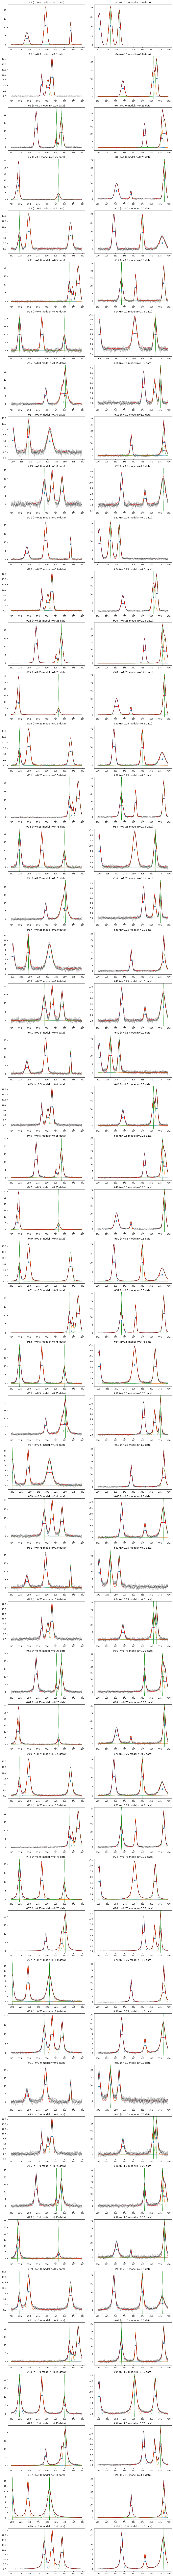

In [20]:
fig.plot_posterior(x_val, ldata, traces, ppc, dims=(int(truns/2),2), figure_size=(12,int(truns*(1.8))),
            savefig='yes', fname=file_basename, showpeaks='yes', sets=tsets, labels=lmodbase, scenario='peakshape')

In [21]:
cnf.close(out_path)